,hour_start_dt,usd_mwh,hour_start_s,onpeak
0,2024-09-01 00:00:00,70.10,1725163200,0
1,2024-09-01 01:00:00,70.10,1725166800,0
2,2024-09-01 02:00:00,70.10,1725170400,0
3,2024-09-01 03:00:00,70.10,1725174000,0
4,2024-09-01 04:00:00,70.10,1725177600,0
...,...,...,...,...
5827,2025-05-01 18:00:00,522.02,1746136800,1
5828,2025-05-01 19:00:00,520.20,1746140400,1
5829,2025-05-01 20:00:00,77.95,1746144000,0
5830,2025-05-01 21:00:00,67.80,1746147600,0


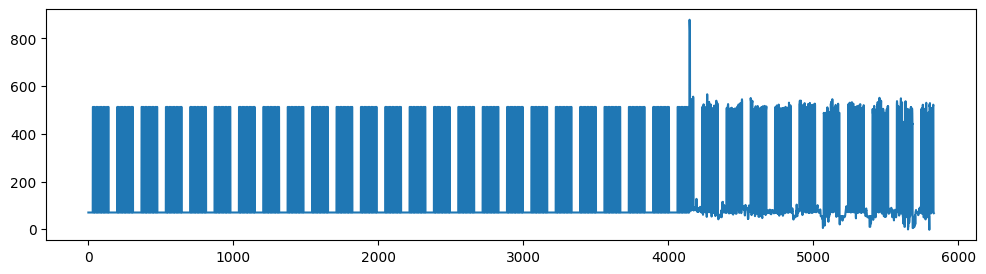

/var/folders/1m/zr3l918x2s76ccl63lx5cst40000gn/T/ipykernel_86696/624690348.py:59: DtypeWarning: Columns (30,37,42,44,50,52,53,59,60,61,63,64,70,72,73,89,97,98,99,100,101,102,103,104,105,106,107,108,115,118,120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/thomas/Downloads/millinocket_weather_2024_2025.csv')
/var/folders/1m/zr3l918x2s76ccl63lx5cst40000gn/T/ipykernel_86696/624690348.py:73: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['DATE'] = pd.to_datetime(df['DATE'])


,DATE,HourlyWindSpeed,HourlyDryBulbTemperature,hour_start_s
0,2024-09-01 00:00:00-04:00,0.0,64.0,1725163200
1,2024-09-01 01:00:00-04:00,0.0,64.0,1725166800
2,2024-09-01 02:00:00-04:00,3.0,64.0,1725170400
3,2024-09-01 03:00:00-04:00,0.0,65.0,1725174000
4,2024-09-01 04:00:00-04:00,2.5,65.0,1725177600
...,...,...,...,...
5519,2025-04-21 22:00:00-04:00,0.0,48.0,1745287200
5520,2025-04-21 23:00:00-04:00,6.0,44.0,1745290800
5521,2025-04-22 00:00:00-04:00,0.0,43.0,1745294400
5522,2025-04-22 01:00:00-04:00,3.0,41.0,1745298000


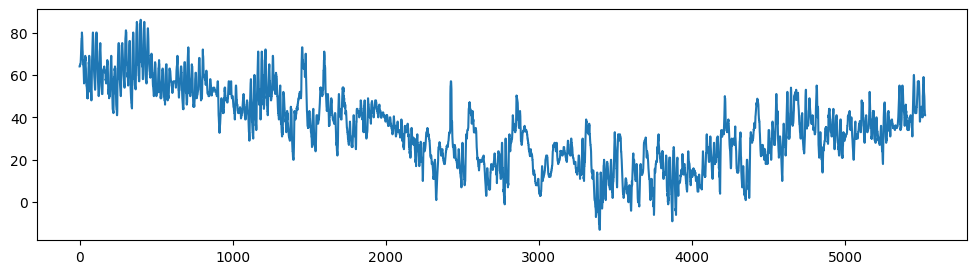

In [1]:
import pandas as pd
import pendulum
import matplotlib.pyplot as plt

# PRICES
df = pd.read_csv('price_forecast_dates.csv')
data = {
    'hour_start_s': [int(x) for x in list(df['unix_s'])],
    'usd_mwh': [x+y for x,y in zip(list(df['tariff']), list(df['lmp']))],
}
data['hour_start_dt'] = [pendulum.from_timestamp(x, tz='America/New_York') for x in list(data['hour_start_s'])]
initial_dates = [pendulum.from_timestamp(x, tz='America/New_York') for x in list(data['hour_start_s'])]
data['onpeak'] = [1 if x.weekday() < 5 and x.hour in [7,8,9,10,11,16,17,18,19] else 0 for x in data['hour_start_dt']]
data['hour_start_cropped'] = [x for x in data['hour_start_dt'] if x >= pendulum.datetime(2024, 9, 1, tz='America/New_York')]
data['hour_start_cropped'] = [x.to_datetime_string() for x in data['hour_start_cropped']]
offset = len(data['usd_mwh']) - len(data['hour_start_cropped'])
data = {
    'hour_start_s': data['hour_start_s'][offset:], 
    'hour_start_dt': data['hour_start_cropped'], 
    'usd_mwh': data['usd_mwh'][offset:], 
    'onpeak': data['onpeak'][offset:]
    }
prices_df = pd.DataFrame(data)

# ALL DATES
from datetime import timedelta
all_times = sorted([initial_dates[0]-timedelta(hours=x) for x in range(4147)]) + list(initial_dates)
times_str = [x.to_datetime_string() for x in all_times]
hour_start_s = [int(x.timestamp()) for x in all_times]
onpeak_column = [1 if x.weekday() < 5 and x.hour in [7,8,9,10,11,16,17,18,19] else 0 for x in all_times]
times_df = pd.DataFrame({'hour_start_dt': times_str, 'hour_start_s': hour_start_s, 'onpeak': onpeak_column})

# MERGED
final_prices_df = pd.merge(times_df, prices_df, on='hour_start_dt', how='outer')

for col in final_prices_df.columns:
    if col.endswith('_x') and col[:-2] + '_y' in final_prices_df.columns:
        base_col = col[:-2]
        final_prices_df[base_col] = final_prices_df[col].fillna(final_prices_df[col[:-2] + '_y'])
        final_prices_df.drop([col, col[:-2] + '_y'], axis=1, inplace=True)

onpeak_df = final_prices_df[final_prices_df['onpeak'] == 1].dropna()
offpeak_df = final_prices_df[final_prices_df['onpeak'] == 0].dropna()
average_onpeak_price = round(sum(onpeak_df['usd_mwh']) / len(onpeak_df), 2)
average_offpeak_price = round(sum(offpeak_df['usd_mwh']) / len(offpeak_df), 2)

final_prices_df['usd_mwh'] = final_prices_df['usd_mwh'].fillna(
    final_prices_df['onpeak'].apply(lambda x: average_onpeak_price if x == 1 else average_offpeak_price)
)
final_prices_df['usd_mwh'] = final_prices_df['usd_mwh'].round(2)
final_prices_df.dropna(inplace=True)

display(final_prices_df)
plt.figure(figsize=(12,3))
plt.plot(final_prices_df['usd_mwh'])
plt.show()

# FINAL WEATHER
df = pd.read_csv('/Users/thomas/Downloads/millinocket_weather_2024_2025.csv')
df = df[['DATE', 'HourlyWindSpeed', 'HourlyDryBulbTemperature']]

df['DATE'] = pd.to_datetime(df['DATE'])
df['HourlyDryBulbTemperature'] = [str(x).replace('s', '') for x in df['HourlyDryBulbTemperature']]
df['HourlyDryBulbTemperature'] = [float(x) for x in df['HourlyDryBulbTemperature']]
first_date = pendulum.datetime(list(df['DATE'])[0].year, list(df['DATE'])[0].month, list(df['DATE'])[0].day, 0, tz='America/New_York')
dates_temp = [first_date] + [pendulum.datetime(x.year, x.month, x.day, x.hour, x.minute, tz='America/New_York') for x in list(df['DATE'])[1:]]
df['DATE'] = [str(x.add(hours=1).replace(minute=0, second=0)) if x.minute > 30 else str(x.replace(minute=0, second=0)) for x in dates_temp]
df = df.groupby('DATE').agg({'HourlyWindSpeed': 'mean', 'HourlyDryBulbTemperature': 'mean'}).reset_index()
df['HourlyWindSpeed'] = df['HourlyWindSpeed'].round(1)
df['HourlyDryBulbTemperature'] = df['HourlyDryBulbTemperature'].round(1)

df = df.ffill()
df['DATE'] = pd.to_datetime(df['DATE'])
df['hour_start_s'] = [int(x.timestamp()) for x in df['DATE']]

final_weather_df = df.copy()
display(final_weather_df)
plt.figure(figsize=(12,3))
plt.plot(final_weather_df['HourlyDryBulbTemperature'])
plt.show()

,date,hour_start_s,usd_mwh,oat_f,ws_mph
0,2024-09-01 00:00:00-04:00,1725163200,70.10,64.0,0.0
1,2024-09-01 01:00:00-04:00,1725166800,70.10,64.0,0.0
2,2024-09-01 02:00:00-04:00,1725170400,70.10,64.0,3.0
3,2024-09-01 03:00:00-04:00,1725174000,70.10,65.0,0.0
4,2024-09-01 04:00:00-04:00,1725177600,70.10,65.0,2.5
...,...,...,...,...,...
5520,2025-04-21 22:00:00-04:00,1745287200,57.91,48.0,0.0
5521,2025-04-21 23:00:00-04:00,1745290800,57.24,44.0,6.0
5522,2025-04-22 00:00:00-04:00,1745294400,67.26,43.0,0.0
5523,2025-04-22 01:00:00-04:00,1745298000,66.60,41.0,3.0


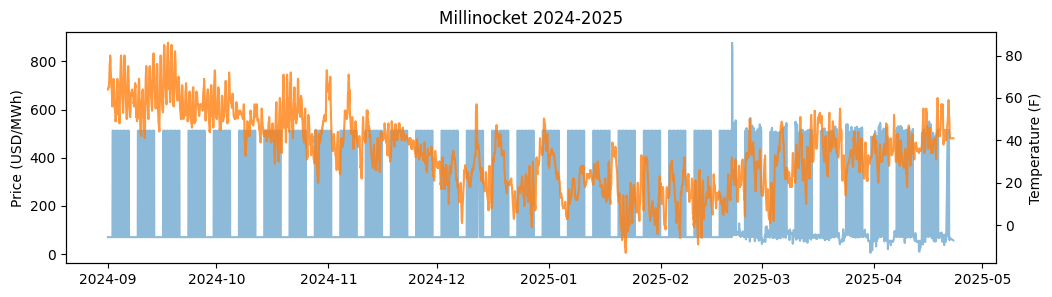

In [2]:
merged_df = pd.merge(final_prices_df, final_weather_df, on='hour_start_s', how='inner')
merged_df = merged_df[['DATE', 'hour_start_s', 'usd_mwh', 'HourlyDryBulbTemperature', 'HourlyWindSpeed']]
merged_df.rename(columns={'DATE': 'date', 'HourlyDryBulbTemperature': 'oat_f', 'HourlyWindSpeed': 'ws_mph'}, inplace=True)
display(merged_df)
merged_df.to_csv('simulation_data.csv', index=False)

# Plot the merged data
fix, ax = plt.subplots(1,1, figsize=(12,3))
ax.plot(merged_df['date'], merged_df['usd_mwh'], label='Price', alpha=0.5)
ax2 = ax.twinx()
ax2.plot(merged_df['date'], merged_df['oat_f'], label='Temperature', color='tab:orange', alpha=0.8)
ax.set_ylabel('Price (USD/MWh)')
ax2.set_ylabel('Temperature (F)')
plt.title('Millinocket 2024-2025')
plt.show()